In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = './data/'
sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

### Data insights, cleaning and feature engineering (Part 1)

Now that we have the datasets loaded, we will perform follwoing tasks
* Data cleaning
* some basic feature engineering
* Data observation

Some of these tasks are interdependent, i.e will be carried out together, such as base don the observations, data will get cleaned, or new features will be added or modified.

In [3]:
def compress(df, verbose = True):
    start = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == "object":
            pass
        elif dtype_name == "bool":
            df[col] = df[col].astype("int8")
        elif dtype_name.startswith("int") or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast = "integer")
        else:
            df[col] = pd.to_numeric(df[col], downcast = "float")
    end = df.memory_usage().sum() / 1024 ** 2
    compressed_per = (100 * (start - end) / start)
    if verbose:
        print("{:.1f}% compressed".format(100 * (start - end) / start))

    return df

In [4]:
dfs = [sales_train, shops, items, item_categories, test]
for df in dfs:
    
    df = compress(df)

54.2% compressed
38.5% compressed
54.2% compressed
39.8% compressed
70.8% compressed


In [5]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [6]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1
1,03.01.2013,0,25,2552,899.00,1
2,05.01.2013,0,25,2552,899.00,-1
3,06.01.2013,0,25,2554,1709.05,1
4,15.01.2013,0,25,2555,1099.00,1
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1
2935845,09.10.2015,33,25,7460,299.00,1
2935846,14.10.2015,33,25,7459,349.00,1
2935847,22.10.2015,33,25,7440,299.00,1


In [7]:
unique_items_grouped = sales_train.groupby('item_id')['item_price'].first().reset_index()
unique_items_grouped

,item_id,item_price
0,0,58.0
1,1,4490.0
2,2,58.0
3,3,100.0
4,4,58.0
...,...,...
21802,22165,59.0
21803,22166,150.0
21804,22167,299.0
21805,22168,799.0


In [8]:
sales_train.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            2935849 non-null  object 
 1   date_block_num  2935849 non-null  int8   
 2   shop_id         2935849 non-null  int8   
 3   item_id         2935849 non-null  int16  
 4   item_price      2935849 non-null  float64
 5   item_cnt_day    2935849 non-null  int16  
dtypes: float64(1), int16(2), int8(2), object(1)
memory usage: 61.6+ MB


### Sales Data Observations
* There are no null records
* Training data set has data from Jan 2013 till Oct 2015 in chronological order. We can keep aside data for Sept and Oct 2015 for testing apart from the actual test dataset given. 
* date_block_num features is a month representation of the sale starting from 0 representing Jan 2013 and Oct 2015 is represented by 33.
* Each record in the dataset represents number of items sold by one shop on a given day. Since the goal is to forecast monthly sales, we can aggregate the number of items sold by each shop for each month. This sum along with the item_price can be used to calculate the total sale for each shop in each month.
* With this aggregation we can drop the date feature and use only the date_block_num feature.
* Item_price is for each item even though it is part of the sales_train dataframe. So total sale ona given dat by a given shop for a given item is item_price * item_cnt_day.

In [9]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [10]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int8  
dtypes: int8(1), object(1)
memory usage: 672.0+ bytes


### Shops observations
* Based on translations of the shop_name data for some samples, it looks like the first token in the name ( seperated by space) is the name of the city in which the shop is located.
* We can extract the city name from this and add a new feature in the shop dataset

Based on the shop names there are 4 pairs of shops where the name is slightly different (just one char changed). Assuming it is a typo we can merge these records. 

In [11]:
shops.loc[shops['shop_id'].isin([0, 57, 1, 58, 10, 11, 39, 40])]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11
39,"РостовНаДону ТРК ""Мегацентр Горизонт""",39
40,"РостовНаДону ТРК ""Мегацентр Горизонт"" Островной",40
57,"Якутск Орджоникидзе, 56",57
58,"Якутск ТЦ ""Центральный""",58


In [12]:
shops.loc[shops['shop_id'] == 57, 'shop_name'] = "!Якутск Орджоникидзе, 56 фран"
shops.loc[shops['shop_id'] == 58, 'shop_name'] = '!Якутск ТЦ "Центральный" фран'
shops.loc[shops['shop_id'] == 11, 'shop_name'] = 'Жуковский ул. Чкалова 39м?'
shops.loc[shops['shop_id'] == 39, 'shop_name'] = 'РостовНаДону ТРК "Мегацентр Горизонт" Островной'
shop_ids_to_delete = [57, 58, 11, 39]
shops = shops[~shops['shop_id'].isin(shop_ids_to_delete)]



In [13]:
shops.loc[shops['shop_id'].isin([0, 57, 1, 58, 10, 11, 39, 40])]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
10,Жуковский ул. Чкалова 39м?,10
40,"РостовНаДону ТРК ""Мегацентр Горизонт"" Островной",40


In [14]:
shops["city"] = shops["shop_name"].apply(lambda x: x.split()[0])

In [15]:
shops["city"].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Ярославль'], dtype=object)

In [16]:
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [17]:
# Now change the shop_ids of the records related to the deleted duplicate shops. 

sales_train.loc[sales_train['shop_id'] == 57, 'shop_id'] = 0
sales_train.loc[sales_train['shop_id'] == 58, 'shop_id'] = 1
sales_train.loc[sales_train['shop_id'] == 11, 'shop_id'] = 10
sales_train.loc[sales_train['shop_id'] == 39, 'shop_id'] = 40

sales_train.groupby('shop_id')['item_id'].count()

shop_id
0     127285
1      77119
2      25991
3      25532
4      38242
5      38179
6      82663
7      58076
8       3412
9       3751
10     21896
12     34694
13     17824
14     36979
15     59511
16     52734
17     22950
18     53227
19     63911
20      1792
21     58133
22     45434
23      6963
24     53032
25    186104
26     53910
27    105366
28    142234
29     49225
30     50860
31    235636
32      7947
33      5027
34      5752
35     58445
36       306
37     39638
38     46013
40     17697
41     41967
42    109253
43     39282
44     39530
45     35891
46     66321
47     56695
48     21612
49     15849
50     65173
51     44433
52     43502
53     52921
54    143480
55     34769
56     69573
59     42108
Name: item_id, dtype: int64

In [18]:
# We need to do the same operation in the test data as well
test.loc[test['shop_id'] == 57, 'shop_id'] = 0
test.loc[test['shop_id'] == 58, 'shop_id'] = 1
test.loc[test['shop_id'] == 11, 'shop_id'] = 10
test.loc[test['shop_id'] == 39, 'shop_id'] = 40
test.groupby('shop_id')['item_id'].count()

shop_id
0     5100
1     5100
2     5100
3     5100
4     5100
5     5100
6     5100
7     5100
10    5100
12    5100
14    5100
15    5100
16    5100
18    5100
19    5100
21    5100
22    5100
24    5100
25    5100
26    5100
28    5100
31    5100
34    5100
35    5100
36    5100
37    5100
38    5100
40    5100
41    5100
42    5100
44    5100
45    5100
46    5100
47    5100
48    5100
49    5100
50    5100
52    5100
53    5100
55    5100
56    5100
59    5100
Name: item_id, dtype: int64

In [19]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [20]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int16 
 2   item_category_id  22170 non-null  int8  
dtypes: int16(1), int8(1), object(1)
memory usage: 238.3+ KB


In [21]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [22]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int8  
dtypes: int8(1), object(1)
memory usage: 888.0+ bytes


### Observations about item Categories
* Based on the translation of the Item Category names, it looks like the first work (before space) represents a category Type , like Books, Games, Accessories etc. These category Types have sub categories.

In [23]:
item_categories["category_type"] = item_categories["item_category_name"].apply(lambda x: x.split()[0])
item_categories["category_type"].value_counts()

category_type
Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: count, dtype: int64

* Though there are about 15 Category Types, some of them have very few sub categories, So we can merge such Category types in to one and call it "Разное" ( Russian for Misc)


In [24]:
def merge_category_type(x):
    if len(item_categories[item_categories["category_type"] == x]) >= 5:
        return x
    else:
        return "Разное"

item_categories["category_type"] = item_categories["category_type"].apply(merge_category_type)
item_categories.head()

,item_category_name,item_category_id,category_type
0,PC - Гарнитуры/Наушники,0,Разное
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


In [25]:
item_categories["category_type"].value_counts()

category_type
Игры          14
Книги         13
Подарки       12
Разное         8
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Name: count, dtype: int64

### Item, Categories and Shops Observations
* None of the datasets for Shops, Items and Item Categories have null records.
* There are 22170 Items ( we need verify for uniqueness) across 84 categories sold in 60 shops.
* Sales data is connected with items and shops using item_id and shop_id. Whereas item is connected with its category using item_category_id in the items dataset.
* We can merge these three datasets with sales dataset and retain only the id features from shop, item and item_category datasets.

We can derive total sale amount by each shop per item from Item_price and item_cnt_day

In [26]:
sales_train['sale_amount'] = sales_train['item_price'] * sales_train['item_cnt_day']

In [27]:
sales_train.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sale_amount
2935844,10.10.2015,33,25,7409,299.0,1,299.0
2935845,09.10.2015,33,25,7460,299.0,1,299.0
2935846,14.10.2015,33,25,7459,349.0,1,349.0
2935847,22.10.2015,33,25,7440,299.0,1,299.0
2935848,03.10.2015,33,25,7460,299.0,1,299.0


### Now merge dataframes in to sales dataframe

In [28]:
train = sales_train.merge(shops, on = 'shop_id', how = 'left')
train = train.merge(items, on = 'item_id', how = 'left')
train = train.merge(item_categories, on = 'item_category_id', how = 'left')

In [29]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sale_amount,shop_name,city,item_name,item_category_id,item_category_name,category_type
0,02.01.2013,0,59,22154,999.00,1,999.00,"Ярославль ТЦ ""Альтаир""",Ярославль,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино
1,03.01.2013,0,25,2552,899.00,1,899.00,"Москва ТРК ""Атриум""",Москва,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,Музыка
2,05.01.2013,0,25,2552,899.00,-1,-899.00,"Москва ТРК ""Атриум""",Москва,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,Музыка
3,06.01.2013,0,25,2554,1709.05,1,1709.05,"Москва ТРК ""Атриум""",Москва,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,Музыка
4,15.01.2013,0,25,2555,1099.00,1,1099.00,"Москва ТРК ""Атриум""",Москва,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,Музыка


In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int8   
 2   shop_id             int8   
 3   item_id             int16  
 4   item_price          float64
 5   item_cnt_day        int16  
 6   sale_amount         float64
 7   shop_name           object 
 8   city                object 
 9   item_name           object 
 10  item_category_id    int8   
 11  item_category_name  object 
 12  category_type       object 
dtypes: float64(2), int16(2), int8(3), object(6)
memory usage: 198.8+ MB


In [31]:
# now check for duplicate rows
count_duplicate_rows = len(train)-len(train.drop_duplicates())
print(f"There are {count_duplicate_rows} duplicate rows")

There are 186 duplicate rows


In [32]:
# remove the duplicate rows leaving only one of the occurances, the first one in this case.

train = train.drop_duplicates()


### Data Visualization

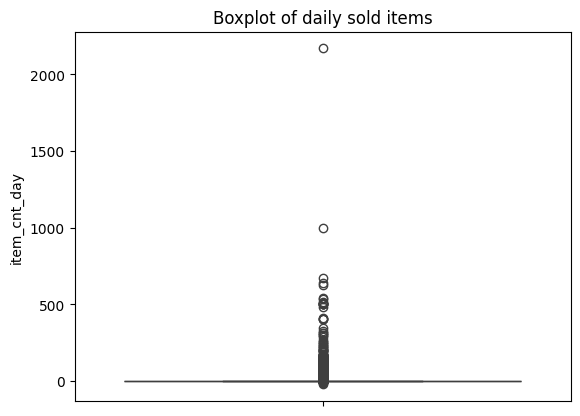

In [33]:
#Sales per day per shop and Item
sns.boxplot(y = "item_cnt_day", data = train);
plt.title("Boxplot of daily sold items")
plt.savefig("./images/box_daily_count")

##### Observation
* The range is wide
* There seems to be out liers.
* Any daily sale per item per shop more than 1000 seems to be an out lier. SO we can remove records with item_cnt_day < 1000 and also less than zero.
* We will keep records with 0 item_cnt_day as items may not sale every day.

We should also check for outliers based on item prices to make sure the total sale amount data does not have any negative values or too high values which are outliers.

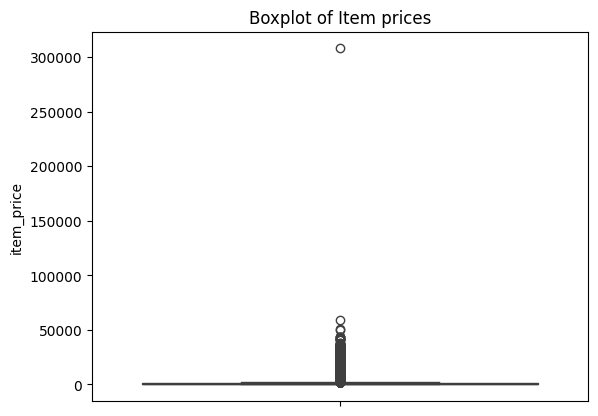

In [34]:
sns.boxplot(y = "item_price", data = train);
plt.title("Boxplot of Item prices")
plt.savefig("./images/box_item_price")

#### Observations
* Here as well the range is wide
* There seems to be outliers 
* Any item with price more than 50000 seems to be outlier.
* We can remove records with item_price > 50000 and also less than or equal to 0.

In [35]:
train = train[train["item_price"] > 0]
train = train[train["item_price"] < 50000]

train = train[train["item_cnt_day"] > 0]
train = train[train["item_cnt_day"] < 1000]


Now lets check for any trends or insights we can find from the data.
1. How the sales are distributed across different months.
2. Which category and category Type items sale more.
3. Which shops have more sales than others
4. Does the city where the shop is located make any difference


##### How the monthly sales are distributed across different months.

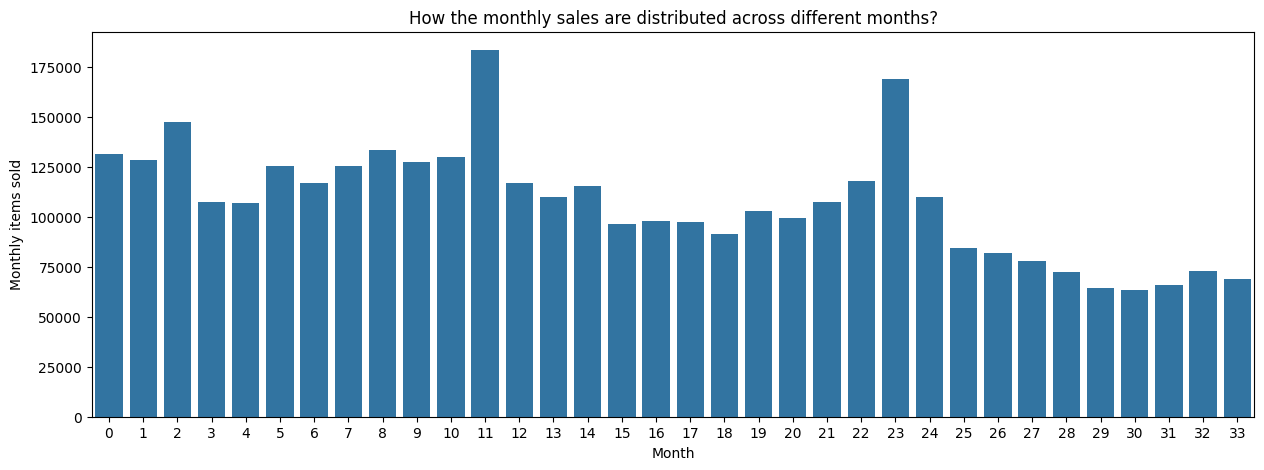

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)


monthly_sum = train.groupby("date_block_num").agg({"item_cnt_day": "sum"}).reset_index()

sns.barplot(x = "date_block_num", y = "item_cnt_day", data = monthly_sum)
ax.set(title = "How the monthly sales are distributed across different months?",
       xlabel = "Month",
       ylabel = "Monthly items sold");
plt.savefig("./images/bar_monthly_items_sold")

#### Observation
* There seems to be a over all declining trend in the number of items sold
* There are couple of months where the sales have gone up and it could related to some promotions or events during those months.

##### Which shops have more sales than others?

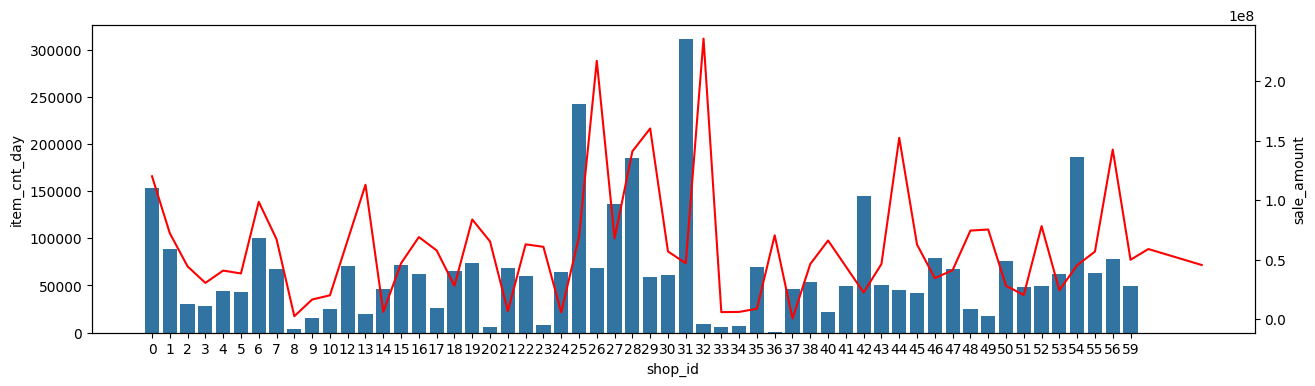

In [37]:
fig, ax1 = plt.subplots()
fig.set_size_inches(15, 4)
ax2 = ax1.twinx()

shop_sum = train.groupby("shop_id").agg({"item_cnt_day": "sum", "sale_amount" : "sum"}).reset_index()


sns.barplot(x = "shop_id", y = "item_cnt_day", data = shop_sum, ax = ax1)
sns.lineplot(x = "shop_id", y = "sale_amount" , data = shop_sum, ax = ax2, color = "red")
ax.set(title = "Which shops have more sales than others?",
       xlabel = "Month",
       ylabel = "# of items sold");
plt.savefig("./images/bar_shop_items_sold")

#### Observation
* Most of the shops have similar sales overall.
* Few shops are selling below average
* couple of shops are are rockstars such as shop-ids 25, 28, 31, 42, and 54
* Total sale amount by each shop more or less follows the trend of number of items sold, with exception of couple of shops. This indicates these shops tend to sale costlier items.

##### Does the city where the shop is located make any difference?

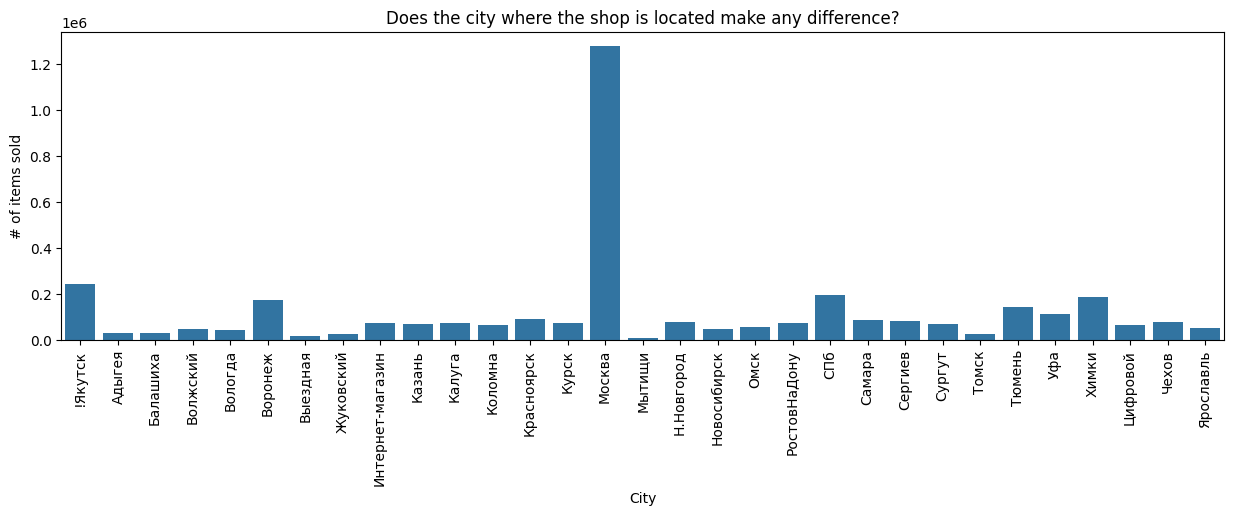

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)

city_sum = train.groupby("city").agg({"item_cnt_day": "sum"}).reset_index()


sns.barplot(x = "city", y = "item_cnt_day", data = city_sum)
ax.set(title = "Does the city where the shop is located make any difference?",
       xlabel = "City",
       ylabel = "# of items sold");
ax.tick_params(axis = "x", labelrotation = 90)
plt.savefig("./images/bar_city_shop_item_sold")

#### Observations
* "MockBa" which is Russian for Moscow, seems to be the city where shops are selling the most.
* All other citys are selling way lower but are close to each other, with couple of cities shining a bit.

##### Which category and category Type items sale more?

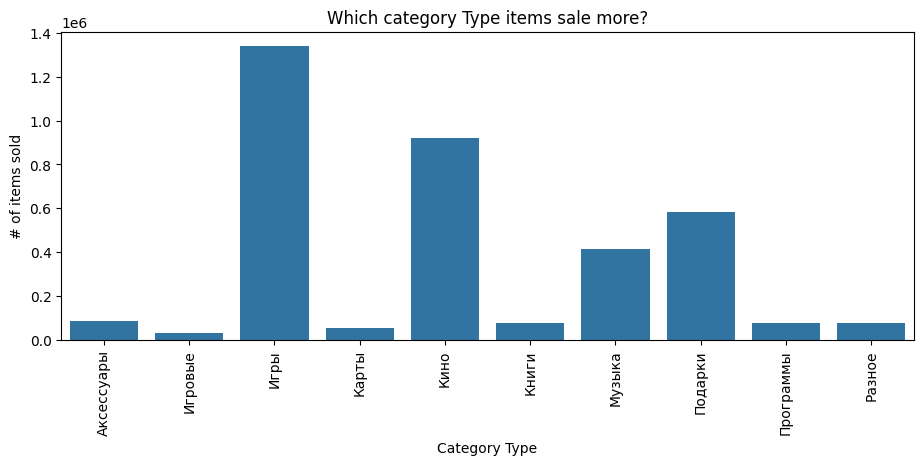

In [39]:
# We will first check by Category type
figure, ax = plt.subplots()
figure.set_size_inches(11, 4)

category_type_sum = train.groupby("category_type").agg({"item_cnt_day": "sum"}).reset_index()


sns.barplot(x = "category_type", y = "item_cnt_day", data = category_type_sum)
ax.set(title = "Which category Type items sale more?",
       xlabel = "Category Type",
       ylabel = "# of items sold");
ax.tick_params(axis = "x", labelrotation = 90)
plt.savefig("./images/bar_category_type_item_sold")

#### Observations
* Four category types are prominent while others are close to each other.
* Игры i.e "Game", Кино i.e "Movies", Музыка i.e "Music" and Подарки i.e "Gifts" are prominent category types

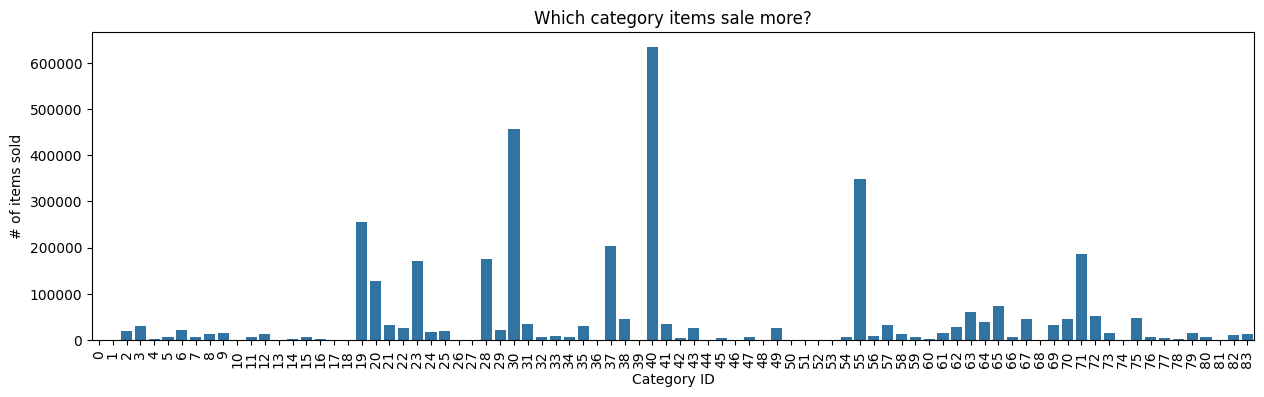

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)

# Total sales by item category
category_sum = train.groupby("item_category_id").agg({"item_cnt_day": "sum"}).reset_index()


sns.barplot(x = "item_category_id", y = "item_cnt_day", data = category_sum)
ax.set(title = "Which category items sale more?",
       xlabel = "Category ID",
       ylabel = "# of items sold");
ax.tick_params(axis = "x", labelrotation = 90)
plt.savefig("./images/bar_category_item_sold")

#### Observations
* Category ID 40 has the highest sales
* Followed by categories 30 and 55.
* Most of the category items are selling in very low range
* This indicates that certain category item sell significantly more than others.

### Baseline Modelling

Now that we have good amount of data cleaning done, and some basic feature engineering done, we will look in tota baseline model. We have decided to use ARMA as a baseline model since the problem is a timeseries problem. 

We will compare other models like LGBM, XGBoost, Logistic Regression with this Baseline model. Before we start with these models we will also perform additional feature egineering ( part 2) to make sure some timeline specific features are added to the dataset so that  these non-timeseries models can be effectively trained.

Since the goal is to forecast item sales for each shop and each item, we will build separate timeseries model for each shop-item combination.



In [41]:
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [42]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [43]:
train.sort_values(by = ['shop_id', 'item_id'])

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sale_amount,shop_name,city,item_name,item_category_id,item_category_name,category_type
173344,21.02.2013,1,0,30,265.0,2,530.0,"!Якутск Орджоникидзе, 56 фран",!Якутск,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,Кино
173345,20.02.2013,1,0,30,265.0,2,530.0,"!Якутск Орджоникидзе, 56 фран",!Якутск,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,Кино
173346,18.02.2013,1,0,30,265.0,4,1060.0,"!Якутск Орджоникидзе, 56 фран",!Якутск,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,Кино
173347,17.02.2013,1,0,30,265.0,4,1060.0,"!Якутск Орджоникидзе, 56 фран",!Якутск,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,Кино
173348,16.02.2013,1,0,30,265.0,9,2385.0,"!Якутск Орджоникидзе, 56 фран",!Якутск,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,Кино
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2724674,21.07.2015,30,59,22164,699.0,1,699.0,"Ярославль ТЦ ""Альтаир""",Ярославль,ЯРОСТЬ (BD),37,Кино - Blu-Ray,Кино
996180,25.10.2013,9,59,22167,299.0,1,299.0,"Ярославль ТЦ ""Альтаир""",Ярославль,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,49,Книги - Методические материалы 1С,Книги
1219808,14.12.2013,11,59,22167,299.0,1,299.0,"Ярославль ТЦ ""Альтаир""",Ярославль,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,49,Книги - Методические материалы 1С,Книги
1219809,03.12.2013,11,59,22167,299.0,1,299.0,"Ярославль ТЦ ""Альтаир""",Ярославль,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,49,Книги - Методические материалы 1С,Книги


In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2928301 entries, 0 to 2935848
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int8   
 2   shop_id             int8   
 3   item_id             int16  
 4   item_price          float64
 5   item_cnt_day        int16  
 6   sale_amount         float64
 7   shop_name           object 
 8   city                object 
 9   item_name           object 
 10  item_category_id    int8   
 11  item_category_name  object 
 12  category_type       object 
dtypes: float64(2), int16(2), int8(3), object(6)
memory usage: 220.6+ MB


We will test with one sample shop_id and item_id.
Since every item may not sell on every month, fill the dataframe with filler records for months when the item did not get sell.

In [45]:
store_1_item_30 = train[(train['shop_id'] == 0) & (train['item_id'] == 30)]
store_1_item_30
store_1_item_30_monthly = store_1_item_30.groupby("date_block_num").agg({"item_cnt_day": "sum"})
store_1_item_30_monthly

,item_cnt_day
date_block_num,
1,31
2,24
3,3
4,1
6,1
7,1
8,1
9,1
10,1


In [46]:
store_1_item_30 = train[(train['shop_id'] == 0) & (train['item_id'] == 30)]
store_1_item_30_monthly = store_1_item_30.groupby("date_block_num").agg({"item_cnt_day": "sum"})

# Make sure 'date' is datetime
#store_1_item_30["date"] = pd.to_datetime(store_1_item_30["date"])
# Set date as index
#store_1_item_30_monthly = store_1_item_30_monthly.set_index("date_block_num")

# Create full daily date range
#full_range = pd.date_range(start=store_1_item_30.index.min(), end=store_1_item_30.index.max())
full_range = pd.Index(range(0, 34))
# Reindex and fill missing with 0
store_1_item_30_monthly = store_1_item_30_monthly.reindex(full_range, fill_value=0)

# Rename index back to 'date'
store_1_item_30_monthly.index.name = "month"

store_1_item_30_monthly.head()



,item_cnt_day
month,
0,0
1,31
2,24
3,3
4,1


In [47]:
X_train, X_test = store_1_item_30_monthly.iloc[:-2], store_1_item_30_monthly.iloc[-2:]

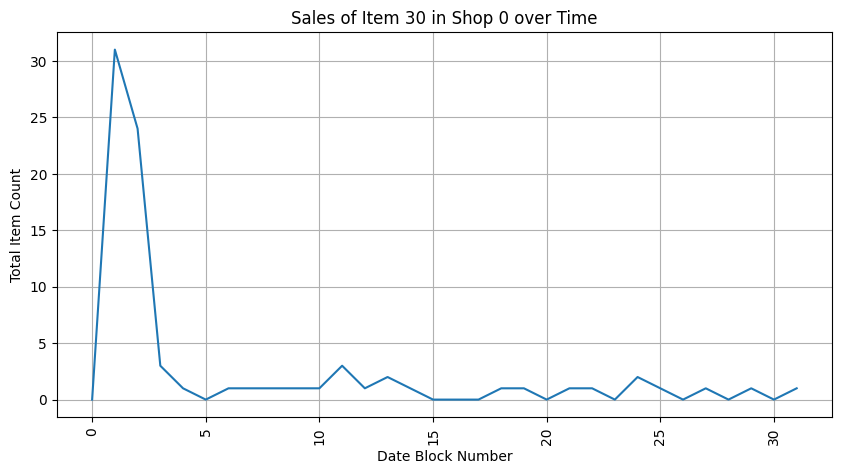

In [48]:


plt.figure(figsize=(10,5))
plt.plot(X_train.index, X_train["item_cnt_day"])
plt.xlabel("Date Block Number")
plt.ylabel("Total Item Count")
plt.title("Sales of Item 30 in Shop 0 over Time")
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

In [49]:
result = adfuller(X_train['item_cnt_day'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])


# If p-value < 0.05, the series is likely stationary.

# If p-value >= 0.05, the series is non-stationary and needs differencing.

if result[1] < 0.05:
  print("The series is likely stationary.")
else:
  print("The series is non-stationary and needs differencing.")

ADF Statistic: -3.2903510774818674
p-value: 0.015315329557108391
The series is likely stationary.


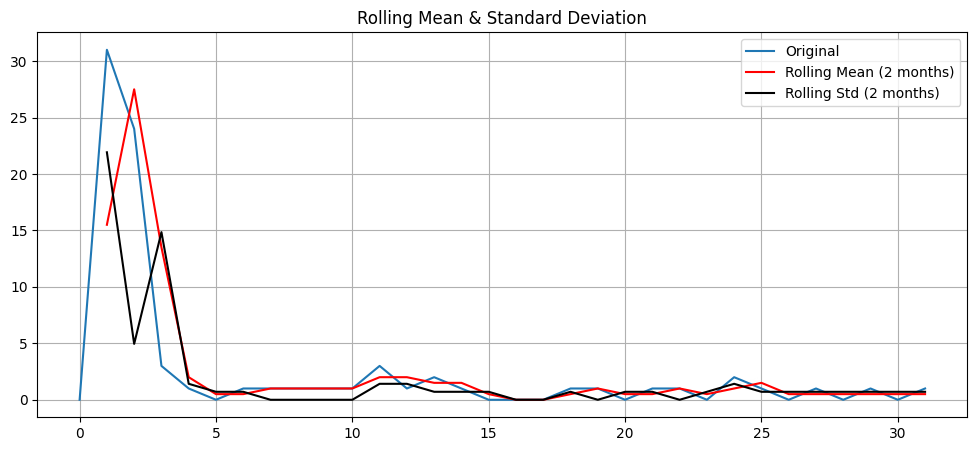

In [50]:

#  in a stationary series, the rolling mean and std should be relatively flat over time.

# Compute rolling statistics
rolling_mean = X_train['item_cnt_day'].rolling(window=2).mean()
rolling_std = X_train['item_cnt_day'].rolling(window=2).std()

# Plot original series with rolling mean and std
plt.figure(figsize=(12, 5))
plt.plot(X_train['item_cnt_day'], label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean (2 months)')
plt.plot(rolling_std, color='black', label='Rolling Std (2 months)')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.grid(True)
plt.show()


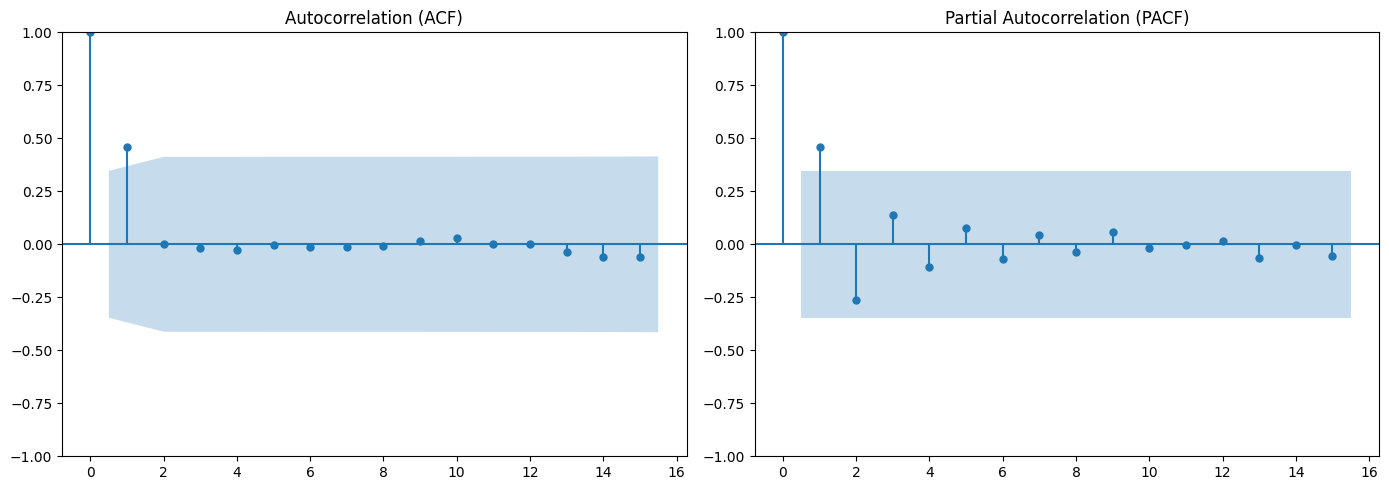

In [51]:


plt.figure(figsize=(14, 5))

# ACF
plt.subplot(1, 2, 1)
plot_acf(X_train['item_cnt_day'], lags=15, ax=plt.gca())
plt.title('Autocorrelation (ACF)')

# PACF
plt.subplot(1, 2, 2)
plot_pacf(X_train['item_cnt_day'], lags=15, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation (PACF)')

plt.tight_layout()
plt.show()

In [52]:
y_train = X_train["item_cnt_day"]
# Fit ARIMA model (p=1, d=0, q=1)
model = ARIMA(y_train, order=(1, 0, 1))
arma = model.fit()

# Forecast next 30 days
preds = arma.forecast(steps=2)

# Make sure y_test matches length (30 days here)
y_test = X_test["item_cnt_day"]  # if X_test is a DataFrame with item_cnt_day column

# Compute MSE
mse_test = mean_squared_error(y_test, preds)

print("Test MSE:", mse_test)
preds


Test MSE: 10.967602695160169


32    4.023218
33    2.397692
Name: predicted_mean, dtype: float64

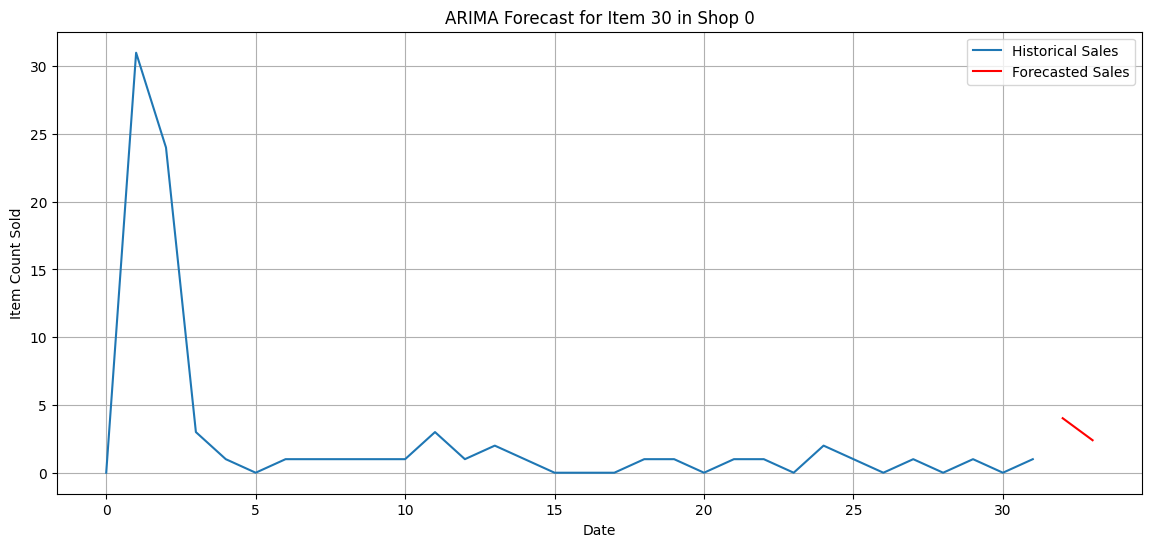

In [53]:
last_month = X_train.index.max()
future_dates = pd.Index(range(last_month + 1, 34))

# Convert forecast to a Series with datetime index
forecast_series = pd.Series(preds, index=future_dates)

# Plot
plt.figure(figsize=(14,6))
plt.plot(X_train.index, y_train, label="Historical Sales")
plt.plot(forecast_series.index, forecast_series, label="Forecasted Sales", color='red')
plt.xlabel("Date")
plt.ylabel("Item Count Sold")
plt.title("ARIMA Forecast for Item 30 in Shop 0")
plt.legend()
plt.grid(True)
plt.show()

Based on one sample Modelling task, we can now build time series ARMA model for each shop-item combo programatically.
    

In [54]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56 entries, 0 to 59
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  56 non-null     object
 1   shop_id    56 non-null     int8  
 2   city       56 non-null     object
dtypes: int8(1), object(2)
memory usage: 1.4+ KB


In [55]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int16 
 2   item_category_id  22170 non-null  int8  
dtypes: int16(1), int8(1), object(1)
memory usage: 238.3+ KB


In [56]:
shop_ids= pd.Series(shops['shop_id'])
item_ids = pd.Series(items['item_id'])

In [57]:
train['shop_item'] = train['shop_id'].astype(str) + "_" + train['item_id'].astype(str)
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sale_amount,shop_name,city,item_name,item_category_id,item_category_name,category_type,shop_item
0,02.01.2013,0,59,22154,999.00,1,999.00,"Ярославль ТЦ ""Альтаир""",Ярославль,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино,59_22154
1,03.01.2013,0,25,2552,899.00,1,899.00,"Москва ТРК ""Атриум""",Москва,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,Музыка,25_2552
3,06.01.2013,0,25,2554,1709.05,1,1709.05,"Москва ТРК ""Атриум""",Москва,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,Музыка,25_2554
4,15.01.2013,0,25,2555,1099.00,1,1099.00,"Москва ТРК ""Атриум""",Москва,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,Музыка,25_2555
5,10.01.2013,0,25,2564,349.00,1,349.00,"Москва ТРК ""Атриум""",Москва,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео,Музыка,25_2564


In [58]:
len(train['shop_item'].unique())

418198

In [59]:
# we will cleanup all the temp objects and dataframe we created and do garbage collection, to save memopry for the full trainining.
import gc
del X_train, X_test, sales_train, shops, items, item_categories, unique_items_grouped, monthly_sum, shop_sum, city_sum, category_type_sum
del category_sum, store_1_item_30, store_1_item_30_monthly, result, rolling_mean, rolling_std, y_train, mse_test, preds, forecast_series
gc.collect()
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sale_amount,shop_name,city,item_name,item_category_id,item_category_name,category_type,shop_item
0,02.01.2013,0,59,22154,999.00,1,999.00,"Ярославль ТЦ ""Альтаир""",Ярославль,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино,59_22154
1,03.01.2013,0,25,2552,899.00,1,899.00,"Москва ТРК ""Атриум""",Москва,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,Музыка,25_2552
3,06.01.2013,0,25,2554,1709.05,1,1709.05,"Москва ТРК ""Атриум""",Москва,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,Музыка,25_2554
4,15.01.2013,0,25,2555,1099.00,1,1099.00,"Москва ТРК ""Атриум""",Москва,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,Музыка,25_2555
5,10.01.2013,0,25,2564,349.00,1,349.00,"Москва ТРК ""Атриум""",Москва,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео,Музыка,25_2564


In [60]:
train.sort_values(['shop_id', 'item_id'])

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sale_amount,shop_name,city,item_name,item_category_id,item_category_name,category_type,shop_item
173344,21.02.2013,1,0,30,265.0,2,530.0,"!Якутск Орджоникидзе, 56 фран",!Якутск,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,Кино,0_30
173345,20.02.2013,1,0,30,265.0,2,530.0,"!Якутск Орджоникидзе, 56 фран",!Якутск,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,Кино,0_30
173346,18.02.2013,1,0,30,265.0,4,1060.0,"!Якутск Орджоникидзе, 56 фран",!Якутск,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,Кино,0_30
173347,17.02.2013,1,0,30,265.0,4,1060.0,"!Якутск Орджоникидзе, 56 фран",!Якутск,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,Кино,0_30
173348,16.02.2013,1,0,30,265.0,9,2385.0,"!Якутск Орджоникидзе, 56 фран",!Якутск,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,Кино,0_30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2724674,21.07.2015,30,59,22164,699.0,1,699.0,"Ярославль ТЦ ""Альтаир""",Ярославль,ЯРОСТЬ (BD),37,Кино - Blu-Ray,Кино,59_22164
996180,25.10.2013,9,59,22167,299.0,1,299.0,"Ярославль ТЦ ""Альтаир""",Ярославль,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,49,Книги - Методические материалы 1С,Книги,59_22167
1219808,14.12.2013,11,59,22167,299.0,1,299.0,"Ярославль ТЦ ""Альтаир""",Ярославль,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,49,Книги - Методические материалы 1С,Книги,59_22167
1219809,03.12.2013,11,59,22167,299.0,1,299.0,"Ярославль ТЦ ""Альтаир""",Ярославль,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,49,Книги - Методические материалы 1С,Книги,59_22167


In [61]:
train_shop_item_list = train['shop_item'].unique()


In [62]:
train_shop_item_list.sort()
train_shop_item_list

array(['0_100', '0_1000', '0_10000', ..., '9_9782', '9_9785', '9_9904'],
      shape=(418198,), dtype=object)

In [63]:
final_results = {}
full_range = pd.Index(range(0, 34))
#for shop_id in shop_ids:
#    for item_id in item_ids:
for shop_item in train_shop_item_list:
    #print(f"processing for shop_item {shop_item}" )
    print(f"\rProcessing: {shop_item}", end="")
    # filter records for shop_id-item_id combination
    shop_id, item_id = shop_item.split("_")
    #store_item_df = train[(train['shop_id'] == shop_id) & (train['item_id'] == item_id)]
    store_item_df = train[(train['shop_item'] == shop_item)]
    store_item_df = store_item_df.groupby("date_block_num").agg({"item_cnt_day": "sum"})
    # Not every item will sell in every shop, so only if at least one item has sold in the given shop proceed, else check for next item.
    #print(" Length of dataframe before fillinf missing", len(store_item_df))
    if len(store_item_df) > 0:
        # Make sure 'date' is datetime
        #store_item_df["date"] = pd.to_datetime(store_item_df["date"], format='mixed')
        # Set date as index
        #store_item_df = store_item_df.set_index("date")
        #print("length of DF - ", len(store_item_df))
        # Since items may not sell on every day, insert 0 count records for days when the item is not sold.
        # Create full daily date range
        #print("min", store_item_df.index.min())
        #print("min", store_item_df.index.max())
        store_min_index = store_item_df.index.min()
        store_max_index = store_item_df.index.max()
        #format_string = "%d.%m.%Y"
        # Convert the string to a datetime object
        #threshold_date = datetime.strptime('1.10.2015', format_string)
        threshold = 31
        #if store_min_index > threshold_date:
        #    continue
        if store_min_index > threshold:
            continue
        #full_range = pd.date_range(start=store_item_df.index.min(), end=store_item_df.index.max())
        #store_item_df = store_item_df.groupby(store_item_df.index).sum()    
        # Reindex and fill missing with 0
        # Reindex and fill missing with 0
        store_item_df = store_item_df.reindex(full_range, fill_value=0)

        # Rename index back to 'month'
        store_item_df.index.name = "month"
            

        #store_item_df = store_item_df.reindex(full_range, fill_value=0)
                
        # Rename index back to 'date'
        # store_item_df.index.name = "date"
            
        # create Training dataset with all days except last 2 months. Last 2 months records will go in the test set.
        #print("Length of dataframe -", len(store_item_df))
        X_train, X_test = store_item_df.iloc[:-2], store_item_df.iloc[-2:]
        #print("Length of trin DF ", len(X_train))
        # Now we need to find the AD Fuller stats to determine if the timeseries is stationary or not.
        result = adfuller(X_train['item_cnt_day'])
        p_value = result[1]
        # If p-value < 0.05, the series is likely stationary
        # If p-value >= 0.05, the series is non-stationary and needs differencing.
        i = 0
        if p_value >= 0.05:
            while p_value >= 0.05 and i<= 4:
                i += 1
                X_train_Item_cnt_diff = X_train["item_cnt_day"].diff().dropna()
                p_value = adfuller(X_train_Item_cnt_diff)[1]
            y_train = X_train_Item_cnt_diff
        else:
            y_train = X_train["item_cnt_day"]
            
        y_train = X_train["item_cnt_day"]
        # Fit ARIMA model (p=1, d=i, q=1)
        model = ARIMA(y_train, order=(1, i, 1))
        arma = model.fit()
            
        # Forecast next 30 days
        preds = arma.forecast(steps=2)
        results = {}
        results['preds'] = preds
        y_test = X_test["item_cnt_day"]  
            
        # Compute MSE
        mse_test = mean_squared_error(y_test, preds)
        results['mse'] = mse_test
        #results['fit_model'] = model
        #print("Test MSE:", mse_test)
        id = str(shop_id) + "-" + str(item_id)
        final_results[id] = results

Processing: 9_990427

In [64]:
len(final_results)

405923

In [85]:
i = 1
result_df = pd.DataFrame(columns=['shop_id', 'item_id', 'month', 'mse', 'item_cnt'])
for id in final_results:
    #if i == 10:
    #    break
    mse  = final_results[id]['mse']
    preds = final_results[id]['preds']
    shop_id, item_id = id.split("-")
    item_cnt_list = []
    month_list = []
    for pred in preds.keys():
        item_cnt = preds[pred]
        month  = pred
        #print(month)
        #print(item_cnt)
        month_list.append(month)
        item_cnt_list.append(item_cnt)
    #print(id)
    new_rows_df = pd.DataFrame({'shop_id': [shop_id, shop_id], 'item_id': [item_id, item_id], 'month' : month_list, 'mse' : [mse, mse], 'item_cnt' : item_cnt_list})
    result_df = pd.concat([result_df, new_rows_df], ignore_index=True)
    #print(mse)
    #print(preds.keys())
    #i +=1
    
result_df.head()
#del item_cnt_list, month_list, new_rows_df
#gc.collect()


,shop_id,item_id,month,mse,item_cnt
0,0,100,32,0.014440,0.116681
1,0,100,33,0.014440,0.123554
2,0,1000,32,0.032558,0.127071
3,0,1000,33,0.032558,0.221289
4,0,10000,32,0.002286,0.048989


In [87]:
result_df.groupby('month').agg({"mse": "mean"})

,mse
month,
32,30.974102
33,30.974102
